In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt

from pandas_ml_utils.ml.data.splitting import RandomSequences
from pandas_ml_utils import FeaturesAndLabels, Model, ReinforcementModel
from pandas_ml_quant import pd, np, PostProcessedFeaturesAndLabels
from pandas_ml_common import Constant

/usr/lib/tensorflow/lib/python3.7/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/lib/tensorflow/lib/python3.7/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/lib/tensorflow/lib/python3.7/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/lib/tensorflow/lib/python3.7/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as a synonym

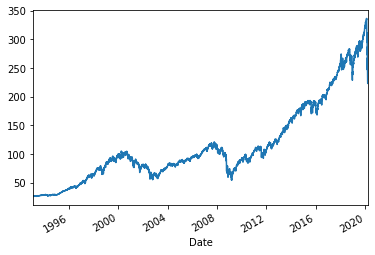

In [2]:
df = pd.fetch_yahoo('SPY')
df["Close"].plot()

In [15]:
(f, s), l, t, w = df._.extract(
    PostProcessedFeaturesAndLabels(
        features=[                
            lambda df: df.ta.candles_as_culb()
        ],
        feature_post_processor=[
            lambda df: df.ta.rnn(280),
            lambda df: df.ta.gaf(image_size=52, sample_range=(0, 1),)
        ],
        labels=[
            Constant(0)
        ],
        targets=[
            lambda df: df["Close"]
        ],
    )
)

print(f._.values.swapaxes(1, 2).swapaxes(2, 3).shape)
f.tail()

(6563, 52, 52, 4)


,close_gaf,upper_gaf,lower_gaf,body_gaf
Date,,,,
2020-03-25,"[[-255.0, -252.96508959696615, -213.5024389847...","[[-115.55590640037387, 133.33837382371337, -17...","[[-109.84357062820753, 136.04206976117183, -12...","[[-237.6232096713101, 47.069527460401574, -140..."
2020-03-26,"[[-255.0, -254.40263457061164, -232.7427725006...","[[-166.92041058395913, 105.97239098248755, -14...","[[-217.21216988656377, 69.41144242459681, -203...","[[-111.64866893891046, 135.19354537214016, -18..."
2020-03-27,"[[-252.84530632772086, -254.46075641792865, -2...","[[-95.87915285720874, 142.43562445139315, -111...","[[-137.36459753277683, 122.46841632937472, 41....","[[255.0, 118.28057728037903, 126.3513095413174..."
2020-03-30,"[[-239.67310007185927, -251.1390456682554, -22...","[[-49.70926957840203, -21.189381851049458, 161...","[[-199.656292390977, 84.00191734360655, -51.03...","[[255.0, 29.463426258976817, 37.82866748175694..."
2020-03-31,"[[-230.7267349395974, -248.85770774641213, -22...","[[60.61687011503742, 40.13891896129015, 200.60...","[[-202.84911913644092, -119.70480784493057, 81...","[[255.0, 4.853753197182405, 88.67580445360773,..."


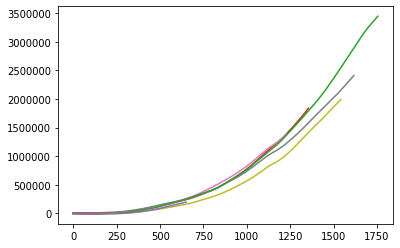

In [21]:
from stable_baselines import PPO2
from stable_baselines.common.vec_env import DummyVecEnv
from pandas_ml_quant.model.rl_trading_agent import TradingAgentGym

fit = df.model.fit(
    ReinforcementModel(
        lambda: PPO2('CnnLstmPolicy',
                     DummyVecEnv([lambda: TradingAgentGym((52, 52, 4), initial_capital=100000, commission=lambda _: 0.25)]),
                     nminibatches=1),
        PostProcessedFeaturesAndLabels(
            features=[                
                lambda df: df.ta.candles_as_culb()
            ],
            feature_post_processor=[
                lambda df: df.ta.rnn(280),
                lambda df: df.ta.gaf(image_size=52, sample_range=(0, 1),)
            ],
            labels=[
                Constant(0)
            ],
            targets=[
                lambda df: df["Close"]
            ],
        ),
    ),
    RandomSequences(0.1, 0.7, max_folds=None),
    total_timesteps=10000,
    verbose=1,
    render='system'
)

fit.model.plot_loss()

In [22]:
e = fit.model.rl_model.get_env()


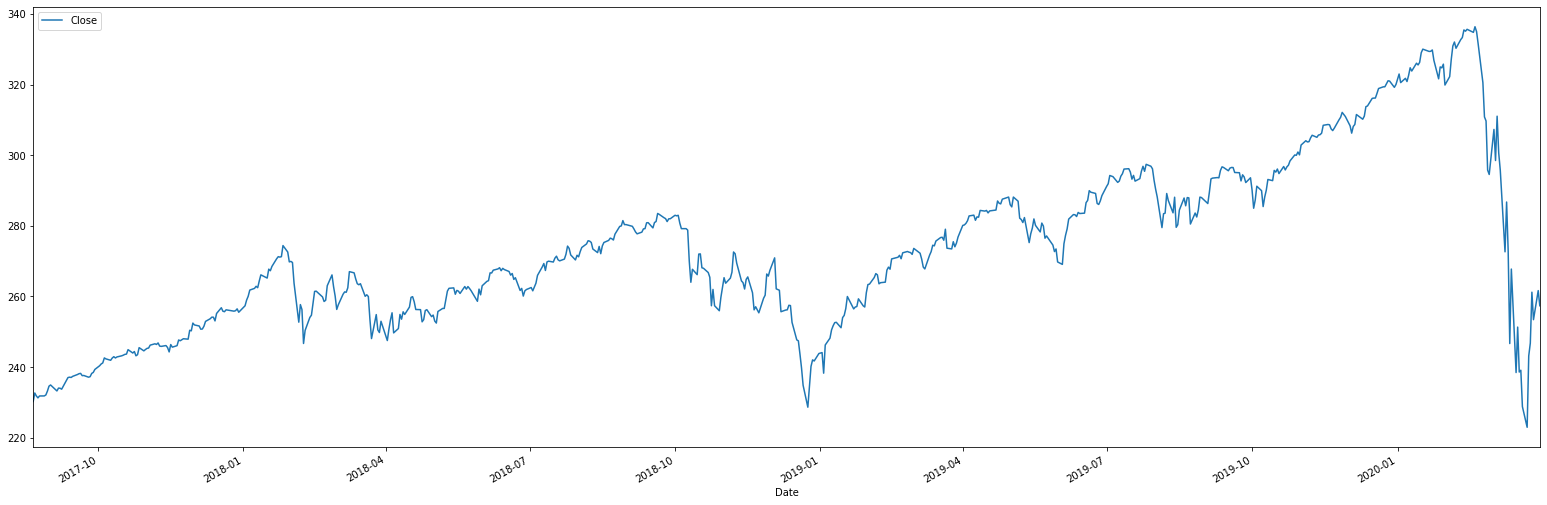

In [31]:
fit.test_summary.df["target"].plot(figsize=(27, 9))

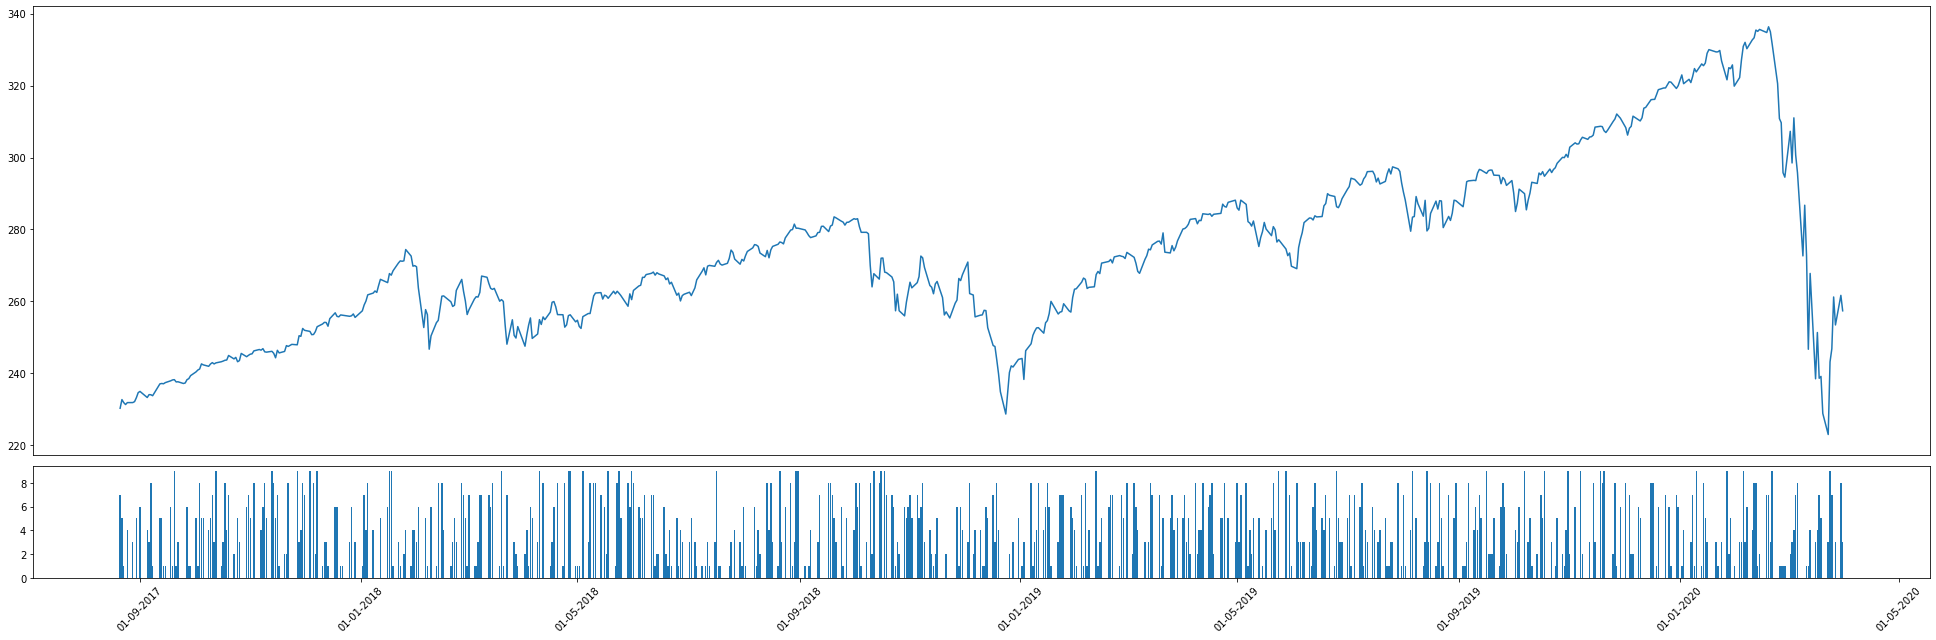

In [37]:
p = fit.test_summary.df.ta.plot(2, 1, figsize=(27, 9))
p.line("target")
p.bar("prediction", panel=1)

In [119]:
from pandas_ml_quant.trading.transaction_log import StreamingTransactionLog
from pandas_ml_utils.constants import PREDICTION_COLUMN_NAME, TARGET_COLUMN_NAME

tdf = fit.test_summary.df
log = StreamingTransactionLog()
tdf[PREDICTION_COLUMN_NAME].apply(lambda action: log.rebalance(action[0]), axis=1)
perf = log.evaluate(tdf[TARGET_COLUMN_NAME, "Close"].rename("prices"))

,0
Date,
2017-08-21,7
2017-08-22,5
2017-08-23,1
2017-08-24,0
2017-08-25,4


,prices,position_open,position_close,position_net,cash_open,cash_close,slippage,cash_net,asset_value,net
Date,,,,,,,,,,
2017-08-21,230.25,7,0,7,-1611.75,0.00,0,-1611.75,1611.75,0.00
2017-08-22,232.66,0,-2,5,0.00,465.32,0,-1146.43,1163.30,16.87
2017-08-23,231.82,0,-4,1,0.00,927.28,0,-219.15,231.82,12.67
2017-08-24,231.28,0,-1,0,0.00,231.28,0,12.13,0.00,12.13
2017-08-25,231.82,4,0,4,-927.28,0.00,0,-915.15,927.28,12.13


array([7, 5, 1, 0, 4])

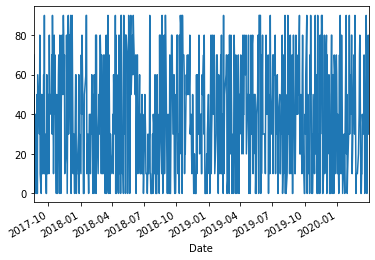

In [80]:

#tdf[PREDICTION_COLUMN_NAME].plot()
tdf[PREDICTION_COLUMN_NAME, "0"].apply(lambda action: action / 10 * 100).plot()
#perf["position_net"].plot()
perf.tail()

display(tdf[PREDICTION_COLUMN_NAME].head())
display(perf.head())
tdf[PREDICTION_COLUMN_NAME, "0"].head().values

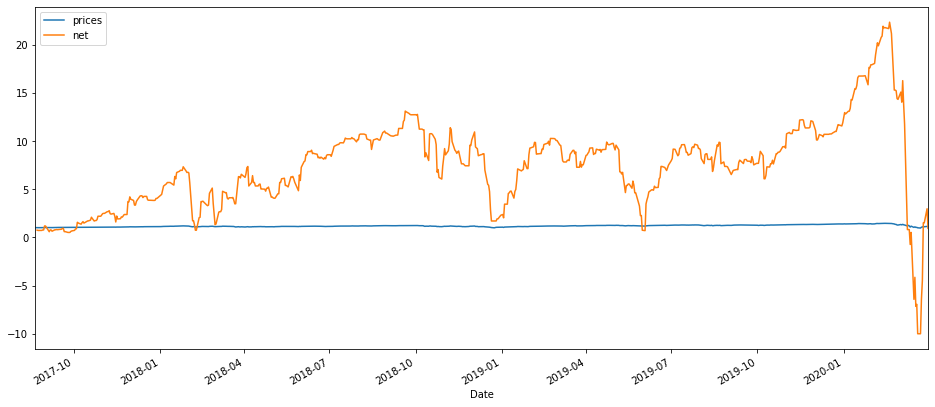

In [115]:
(perf["prices"].pct_change() + 1).cumprod().plot(figsize=(16,7))
(perf["net"].pct_change().replace([np.inf, -np.inf], np.nan) + 1).cumprod().plot()

plt.legend(loc='best')


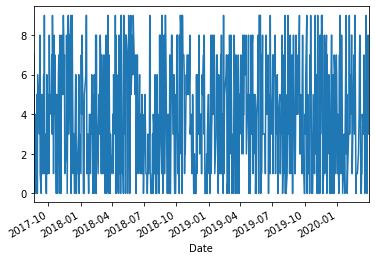

In [117]:
perf["position_net"].plot()

In [71]:
tdf[PREDICTION_COLUMN_NAME].apply(lambda action: action / 10 * 100000).sum()

0    25280000.0
dtype: float64

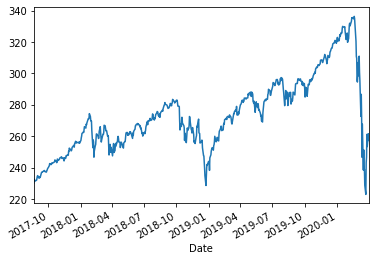

In [51]:
tdf[TARGET_COLUMN_NAME, "Close"].plot()